<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/visiontansformer_convulation_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-dataset/y.npy
/kaggle/input/brain-tumor-dataset/X.npy


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

2025-07-16 01:24:03.872181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752629044.124276      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752629044.197806      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
X = np.load("/kaggle/input/brain-tumor-dataset/X.npy")
y = np.load("/kaggle/input/brain-tumor-dataset/y.npy")

In [ ]:
print("Dataset shapes:", X.shape, y.shape)

Dataset shapes: (7153, 128, 128, 3) (7153,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (5722, 128, 128, 3), Val: (1431, 128, 128, 3)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------
# Hyperparameters
# -----------------------
input_shape = (128, 128, 3)
patch_size = 16
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
transformer_layers = 4
num_heads = 4
num_classes = 4

# -----------------------
# Patches layer
# -----------------------
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# -----------------------
# Patch Encoder layer
# -----------------------
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# -----------------------
# Build the combined model
# -----------------------
def build_hybrid_model():
    inputs = layers.Input(shape=input_shape)

    # ---------------------
    # DCNN Branch
    # ---------------------
    x_cnn = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x_cnn = layers.MaxPooling2D((2,2))(x_cnn)
    x_cnn = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x_cnn)
    x_cnn = layers.MaxPooling2D((2,2))(x_cnn)
    x_cnn = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x_cnn)
    x_cnn = layers.MaxPooling2D((2,2))(x_cnn)
    x_cnn = layers.Flatten()(x_cnn)

    # ---------------------
    # ViT + GRU Branch
    # ---------------------
    x_vit = layers.Rescaling(1./255)(inputs)
    patches = Patches(patch_size)(x_vit)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        encoded_patches = layers.Add()([x3, x2])

    x_vit = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    x_vit = layers.Dropout(0.2)(x_vit)
    x_vit = layers.Flatten()(x_vit)
    x_vit = layers.Reshape((-1, x_vit.shape[-1]))(x_vit)
    x_vit = layers.GRU(256)(x_vit)

    # ---------------------
    # Concatenate DCNN and ViT+GRU
    # ---------------------
    x = layers.concatenate([x_cnn, x_vit])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Build model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# -----------------------
# Compile and summary
# -----------------------
model = build_hybrid_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_2 (Patches) │ (None, None, 768) │          0 │ rescaling_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_2     │ (None, 64, 64)    │     53,312 │ patches_2[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ patch_encoder_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 64, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 64, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_19[0][0]    

 Total params: 12,212,484 (46.59 MB)

 Trainable params: 12,212,484 (46.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Suppose you have:
# X_train shape: (N, 224, 224, 3)
# y_train shape: (N, )

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32)


Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 200s 976ms/step - accuracy: 0.5810 - loss: 1.0119 - val_accuracy: 0.8407 - val_loss: 0.4071
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8284 - loss: 0.4301 - val_accuracy: 0.9015 - val_loss: 0.2479
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 171s 953ms/step - accuracy: 0.9068 - loss: 0.2470 - val_accuracy: 0.9357 - val_loss: 0.2066
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 172s 964ms/step - accuracy: 0.9334 - loss: 0.1589 - val_accuracy: 0.9462 - val_loss: 0.1528
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 172s 962ms/step - accuracy: 0.9651 - loss: 0.0964 - val_accuracy: 0.9427 - val_loss: 0.1690
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 171s 956ms/step - accuracy: 0.9648 - loss: 0.0946 - val_accuracy: 0.9602 - val_loss: 0.1234
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 172s 962ms/step - accuracy: 0.9864 - loss: 0.0445 - val_accuracy: 0.9623 - val_loss: 0.1317
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 173s 967ms/step - accuracy: 0.9866 - lo

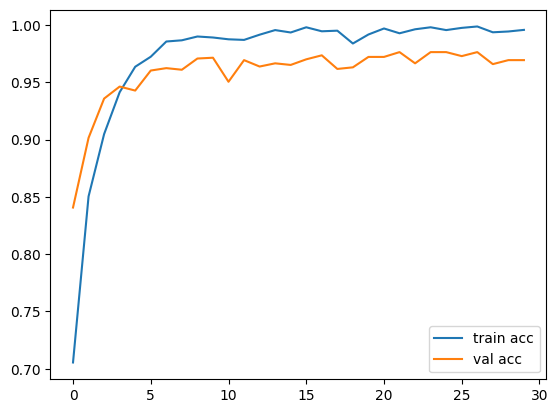

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
